In [17]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [18]:
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy("mixed_float16")

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#tf.config.optimizer.set_jit(False)

In [21]:
def view_random_image(data):
    rand_cat = random.sample(list(train_data['category'].unique()),1)
    rand_img = random.sample(list(data[data['category']==rand_cat[0]]['image_path']),1)

    img = mpimg.imread(rand_img[0])
    plt.imshow(img)
    plt.title(rand_cat[0])
    plt.axis('off')

    print(f'Image shape: {img.shape}')

    return img

def loss_curves(cnn):
    loss = cnn.history['loss']
    val_loss = cnn.history['val_loss']

    accuracy = cnn.history['accuracy']
    val_accuracy = cnn.history['val_accuracy']

    epochs = range(len(cnn.history['loss']))

    plt.plot(epochs, loss, label= "training_loss")
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('loss')
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label= "training_accuracy")
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('accuracy')
    plt.xlabel("epochs")
    plt.legend()


## Load Train/Test Set

In [22]:
dir = '../data/food-101'
# Load the category labels
labels_file = dir+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = dir+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)

# Load the testing dataset
test_file = dir+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)

(75750, 4)
(25250, 4)


Image shape: (512, 512, 3)


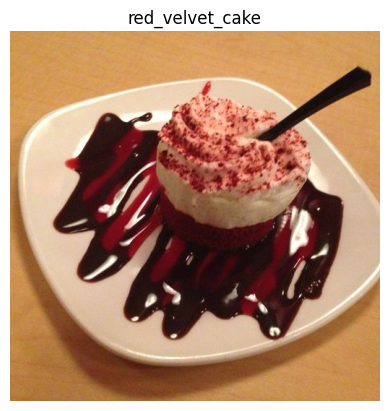

In [23]:
x = view_random_image(train_data)

## Preprocess Data

In [24]:
# Parameters for model training
input_shape = (224, 224, 3)
batch_size = 32

train_gen = ImageDataGenerator()

train_gen_aug = ImageDataGenerator(
                               rotation_range= 20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

test_gen = ImageDataGenerator(validation_split=0.15)


In [25]:
# load image categories and filepaths from dataframe
tf_train_data = train_gen.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)
tf_train_data_aug = train_gen_aug.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)

tf_valid_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, subset='validation')
tf_test_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, subset='training')


Found 75750 validated image filenames belonging to 101 classes.
Found 75750 validated image filenames belonging to 101 classes.
Found 3787 validated image filenames belonging to 101 classes.
Found 21463 validated image filenames belonging to 101 classes.


## CNN Modeling

### EfficientNetB0

In [26]:
def model_checkpoint_callback(dir):
    model_checkpoint_callback =  tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=dir,
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    monitor='val_Accuracy',
                                                    mode='max',
                                                    save_freq='epoch')
    return model_checkpoint_callback

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [13]:
checkpoint_fp = '../models/eff_net/checkpoints/checkpoint.ckpt'

effb0_model = tf.keras.applications.EfficientNetB0(include_top=False)
effb0_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = effb0_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])

hist_effb0_1 = model.fit(tf_train_data,
                        epochs=4,
                        steps_per_epoch=len(tf_train_data),
                        validation_data=tf_valid_data,
                        validation_steps=len(tf_valid_data),
                        callbacks=model_checkpoint_callback(checkpoint_fp)
                        )

Epoch 1/4
 104/2368 [>.............................] - ETA: 19:48 - loss: 3.7386 - Accuracy: 0.2112

KeyboardInterrupt: 

In [78]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 73s 109ms/step - loss: 1.0387 - Accuracy: 0.7189


[1.0387483835220337, 0.7188650369644165]

In [ ]:
model.save('../models/eff_net/base_model')

### Tune on all layers

In [80]:
effb0_model.trainable=True

# drop learning rate as to not change weights too much via fine tuning
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])

In [81]:
checkpoint_fp = '../models/eff_net/checkpoints/checkpoint_tune.ckpt'

hist_effb0_1_fine_tune_all = model.fit(tf_train_data,
                                     epochs=104, # fine tune for an additional 4 epochs
                                     steps_per_epoch=len(tf_train_data),
                                     validation_data=tf_valid_data,
                                     validation_steps=len(tf_valid_data),
                                     initial_epoch=hist_effb0_1.epoch[-1], # start training from last trained epoch in this case training starts at epoch 4
                                     callbacks=[model_checkpoint_callback(checkpoint_fp), callback]
                                     )

Epoch 4/104
2368/2368 [==============================] - 441s 183ms/step - loss: 0.8861 - Accuracy: 0.7598 - val_loss: 0.9299 - val_Accuracy: 0.7449
Epoch 5/104
2368/2368 [==============================] - 433s 183ms/step - loss: 0.5540 - Accuracy: 0.8463 - val_loss: 1.0146 - val_Accuracy: 0.7293
Epoch 6/104
2368/2368 [==============================] - 434s 183ms/step - loss: 0.3193 - Accuracy: 0.9083 - val_loss: 1.0784 - val_Accuracy: 0.7336
Epoch 7/104
2368/2368 [==============================] - 434s 183ms/step - loss: 0.1722 - Accuracy: 0.9478 - val_loss: 1.2179 - val_Accuracy: 0.7354


In [82]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 75s 111ms/step - loss: 0.9904 - Accuracy: 0.7761


[0.9904047250747681, 0.7760797739028931]

In [83]:
model.save('../models/eff_net/model_full_tune')

INFO:tensorflow:Assets written to: ../models/eff_net/model_full_tune\assets


C:\Users\Ivan\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### ConvNeXt

In [27]:
checkpoint_fp = '../models/conv/checkpoints/checkpoint.ckpt'


conv_model = tf.keras.applications.convnext.ConvNeXtBase(include_top=False)
conv_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

x = conv_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_conv = tf.keras.Model(inputs, outputs)

model_conv.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])


In [ ]:
hist_conv = model_conv.fit(tf_train_data,
                           epochs=4,
                           steps_per_epoch=len(tf_train_data),
                           validation_data=tf_valid_data,
                           validation_steps=len(tf_valid_data),
                           callbacks=model_checkpoint_callback(checkpoint_fp))

In [14]:
results = model_conv.evaluate(tf_test_data)

671/671 [==============================] - 148s 208ms/step - loss: 0.6731 - Accuracy: 0.8548


In [33]:
model_conv.save('../models/conv/base_model')

INFO:tensorflow:Assets written to: ../models/conv/base_model\assets


INFO:tensorflow:Assets written to: ../models/conv/base_model\assets


In [13]:
model_conv.trainable=True

# if needed to adjust training layers and inspect layers
#for layer in model_conv.layers[:-15]:
#    layer.trainable = False

#for layer_number, layer in enumerate(model_conv.layers):
#    print(layer_number, layer.name, layer.trainable)

# drop learning rate as to not change weights too much via fine tuning
model_conv.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])

In [14]:
checkpoint_fp = '../models/conv/checkpoints/checkpoint_tune.ckpt'
hist_conv_fine_tune_all = model_conv.fit(tf_train_data,
                                       epochs=104, # fine tune for an additional 4 epochs
                                       steps_per_epoch=len(tf_train_data),
                                       validation_data=tf_valid_data,
                                       validation_steps=len(tf_valid_data),
                                       initial_epoch=3, # start training from last trained epoch in this case training starts at epoch 4
                                       callbacks=[model_checkpoint_callback(checkpoint_fp), callback]
                                       )

Epoch 4/104


InternalError: Graph execution error:

libdevice not found at ./libdevice.10.bc
	 [[{{node cluster_3_1/xla_compile}}]] [Op:__inference_train_function_39824]

In [ ]:
results = model_conv.evaluate(tf_test_data)
results

In [ ]:
model_conv.save('../models/conv/tuned_model')

### Sample load model weights for best performing val_accuracy during training

In [28]:
model_conv.load_weights('../models/conv/checkpoints/checkpoint.ckpt')

In [ ]:
#results = model_conv.evaluate(tf_test_data)
#results

## Make Predictions

In [82]:
# Using best performing saved model ConvNeXt 
results = model_conv.evaluate(tf_test_data)
results

671/671 [==============================] - 149s 213ms/step - loss: 0.6731 - Accuracy: 0.8548


[0.6731467843055725, 0.8547733426094055]

In [83]:
from tensorflow.keras.preprocessing import image


#Using random image from google search
img = image.load_img("../data/imgs/poutine.jpg")
pred_img = image.img_to_array(img)
pred_img = tf.expand_dims(pred_img, axis=0)

In [84]:
predictions = model_conv.predict(pred_img)

pred_label = labels[predictions.argmax()] 
pred_prob = predictions.max()

1/1 [==============================] - 2s 2s/step


(-0.5, 1199.5, 1199.5, -0.5)

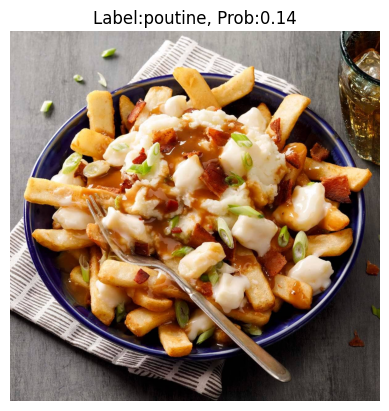

In [85]:
plt.figure()
plt.imshow(img)
plt.title(f'Label:{pred_label}, Prob:{round(float(pred_prob),2)}')
plt.axis(False)